# Pulling rivers from OpenStreetMap (OSM)

In [114]:
import OSMPythonTools
import OSMPythonTools.api
import OSMPythonTools.overpass
from OSMPythonTools.overpass import overpassQueryBuilder
import geopandas
import shapely
import pathlib
import matplotlib

## Waikanae region of interest
OSM uses Latitudes and Longitudes (EPSG:4326) as its coordinate system.

In [6]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849
bbox_nztm2000 = geopandas.GeoDataFrame(geometry=[shapely.geometry.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])],
                                       crs='EPSG:2193')
bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')

## OSM basic structure
There are several parts to the OSM structure that can be used to access individual OSM objects/elements (i.e. a bus top, highway centreline, lake, etc). We will refer to OSM objects as elements, which is the term used by the Python library we are using.

These include the:
* Element ID - these are unique with in each object type
* Element Type - defines the data model structure of the object (see below)
* Element Tag - there are various predefined tags that can be used to describe an object/element.

### OSMPythonTools
OSMPythonTools is an extensive Python wrapper for accessing OSM data. The `OSMPythonTools.overpass.Overpass` class takes care of sending queries and retireving data from OSM, while the `OSMPythonTools.overpass.overpassQueryBuilder` is a class for creating a query for OSM objects in an area. The queries can specify objects to collect by ID, Element Type, Tag, and BBox search.

The `overpassQueryBuilder` has the following generally form:
```
query = overpassQueryBuilder(bbox=[south,
                                   west,
                                   north,
                                   east], 
                             elementType=['nodes', 'way'], selector='"waterway"="river"',
                             out='body', includeGeometry=True)
```

#### Element Type
The **elementType** is the name used by the `overpassQueryBuilder` to define the element type of an object. This can either be a single string, or a list of strings, depending if one or multiple types should be retrieved.

The element type define the OSM data model component of each OSM object. There are three basic options: nodes, way and relation. These can be losely defined as:
* nodes - are points on the maps (in latitude and longitude)
* way - on the other hand is a ordered list of nodes, which could correspond to a street or the outline of a house.
* relation - which is also an ordered list containing either nodes, ways or even other relations. It is used to model logical or geographic relationships between objects.

#### Element Tag
Various tags can be added to an OSM object. These can be specified in the `overpassQueryBuilder` by the **selector** keyword. This can be a string or list. Only objects with these tags with be retrieved. This can be a list or string. If it is a list only objects with all of those tags with be retrived. The page defines all OSM tags, and while the [waterways page](https://wiki.openstreetmap.org/wiki/Waterways) describes waterway related tags. 

# Code example
## Construct query

In [7]:
query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                   bbox_lat_long.bounds.minx[0],
                                   bbox_lat_long.bounds.maxy[0],
                                   bbox_lat_long.bounds.maxx[0]], 
                             elementType='way', selector='waterway',
                             out='body', includeGeometry=True)

## Perform query

In [8]:
overpass = OSMPythonTools.overpass.Overpass()
rivers = overpass.query(query)

[overpass] downloading data: [timeout:25][out:json];(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;


## Extract geometries

<AxesSubplot:>

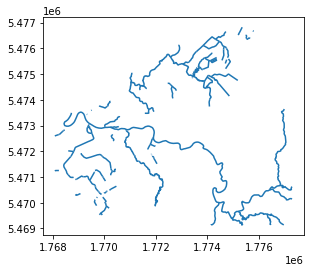

In [10]:
rivers_df = geopandas.GeoDataFrame(geometry=[element.geometry() for element in rivers.elements()],
                       crs='EPSG:4326').to_crs('EPSG:2193')
rivers_df = rivers_df.clip(bbox_nztm2000)

## Filter polylines
* Keep only polylines that don't overlap with a river polygon
* Keep only polylines of a length a channel can be estimated - say 10 pixels?

In [105]:
filter_length = 500

In [106]:
main_river_path = pathlib.Path(r"C:\Users\pearsonra\Documents\data\Waikanae\river_bathymetry\flat_water_polygon.geojson")
main_river_polygon = geopandas.read_file(main_river_path)

In [107]:
clipped_rivers = geopandas.GeoDataFrame(rivers_df.overlay(main_river_polygon, how='difference'), crs=2193)

In [108]:
clipped_rivers = clipped_rivers.explode(index_parts=False)
filtered_rivers = clipped_rivers[clipped_rivers.length > filter_length]

Text(0.5, 1.0, 'Filtered by length')

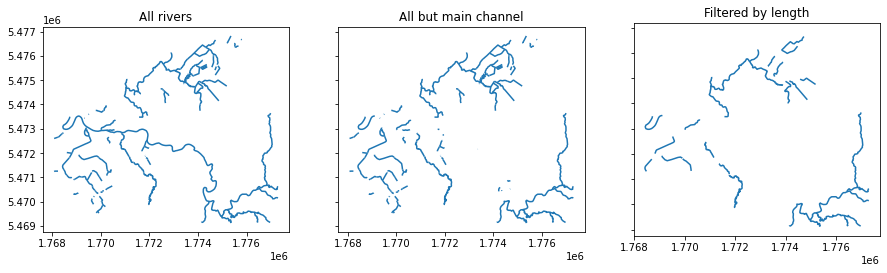

In [119]:
f, axs = matplotlib.pyplot.subplots(1, 3, sharey=True, figsize=(15,6))
rivers_df.plot(ax=axs[0])
clipped_rivers.plot(ax=axs[1])
filtered_rivers.plot(ax=axs[2])
axs[0].set_title("All rivers"); axs[1].set_title("All but main channel"); axs[2].set_title("Filtered by length")

## Create Polygons and sample
* Specify width of drains
* Sample from high resolution DEM

In [121]:
drain_width = 5

In [125]:
drain_polygons = filtered_rivers.buffer(drain_width)